In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
from numpy.core.fromnumeric import size
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules import module
from tqdm import tqdm
import yaml
from torch import optim
import torchvision
from natsort import natsorted
from utils.auxillary import read_config, get_files, tensor2np
from utils.load_data import TrainDataset, Dataloading, TestDataset
from utils.metrics import Results, get_all_metrics

c:\Users\domin\Anaconda3\envs\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read configs

In [2]:
cfg = read_config('configs/config.yml')
cfg

{'RUN_NAME': 'HRNet',
 'N_CLASSES': 1,
 'INPUT_SIZE': 64,
 'EPOCHS': 3,
 'LEARNING_RATE': 0.002,
 'START_FRAME': 8,
 'DROP_RATE': 0.5,
 'DATA_PATH': 'input/sanitycheck/',
 'IMAGE_PATH': 'image/',
 'MASK_PATH': 'predicted/',
 'GT_PATH': 'groundtruth/',
 'LOG_PATH': 'working/runsLog/',
 'SAVE_PATH': 'working/',
 'MODEL_PATH': 'working/checkpoint_',
 'EXCEL_PATH': 'working/excel_result.xlsx',
 'RANDOM_SEED': 42,
 'VALID_RATIO': 0.1,
 'BATCH_SIZE': 8,
 'NUM_WORKERS': 1}

# Get file, image and mask list

In [3]:
fileList = get_files(cfg['DATA_PATH'])
# fileList = natsorted(fileList, key=lambda x: int(os.path.splitext(x)[0]))
imageList = get_files(os.path.join(cfg['DATA_PATH'], cfg['MASK_PATH']))
imageList = sorted(imageList, key=lambda x: int(os.path.splitext(x)[0]))
maskList = get_files(os.path.join(cfg['DATA_PATH'], cfg['GT_PATH']))
maskList = sorted(maskList, key=lambda x: int(os.path.splitext(x)[0]))

In [4]:
print('Using torch %s %s' % (
torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.12.1+cpu CPU


In [5]:
# import torchvision.io as io
# def get_tensors_list(image_paths: list)-> list:
#     """Converts image to pytorch tensors

#     Args:
#         image_paths: a list of image paths to convert

#     Return:
#         tensors_list: a list of image tensors
#     """

#     tensors_list = []

#     for i in range(len(image_paths)):

#         img = io.read_image(image_paths[i])
#         img = img.squeeze(0)
#         tensors_list.append(img)

#     return tensors_list


In [6]:
# image_path = ['CHASEDB1_all/left/Image_01L.jpg']
# mask_path = ['CHASEDB1_all/L_1stHO/Image_01L_1stHO.png']
# image_tensor = get_tensors_list(image_path)
# mask_tensor = get_tensors_list(mask_path)  
# mask_tensor[0] = mask_tensor[0].unsqueeze(0)
# test = torch.vstack((image_tensor[0], mask_tensor[0]))
# test.shape

# Get dataset - train, valid and test

In [7]:
# dataset = TrainDataset(cfg, imageList, maskList, root_dir=cfg['DATA_PATH'])
testdataset = TestDataset(cfg, imageList, maskList, root_dir=cfg['DATA_PATH'])

In [8]:
# testdataset = STLDataset(cfg, fileList = fileList, root_dir = cfg['DATA_PATH'])
dataset = TrainDataset(cfg, fileList = fileList, root_dir = cfg['DATA_PATH'])


In [9]:
train_dataset,valid_dataset = Dataloading.get_dataset(dataset=dataset,random_seed = cfg['RANDOM_SEED'],valid_ratio=0.12)

0 (300, 500) (300, 500)
1 (300, 500) (300, 500)
2 (300, 500) (300, 500)
3 (300, 500) (300, 500)


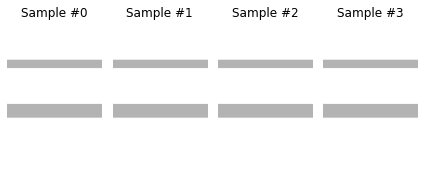

0 (300, 500) (300, 500)
1 (300, 500) (300, 500)
2 (300, 500) (300, 500)
3 (300, 500) (300, 500)


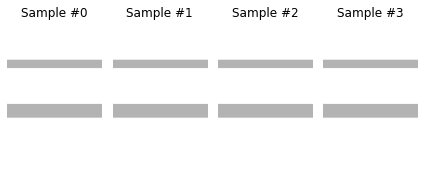

In [10]:
Dataloading.show_dataset(dataset)
Dataloading.show_dataset(testdataset)

# HRNET config

In [11]:
from configs.hrnet_config import get_cfg_defaults
modelcfg = get_cfg_defaults()
# cfg.merge_from_file("config.yml")
modelcfg.freeze()
print(modelcfg)

ALIGN_CORNERS: None
BN_MOMENTUM: 1
CHANNELS: 1
FINAL_CONV_KERNEL: 1
PRETRAINED: working\saved_model.pth
STAGE1:
  BLOCK: BOTTLENECK
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2]
  NUM_BRANCHES: 1
  NUM_CHANNELS: [64]
  NUM_MODULES: 1
STAGE2:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2]
  NUM_BRANCHES: 2
  NUM_CHANNELS: [18, 36]
  NUM_MODULES: 1
STAGE3:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2, 2]
  NUM_BRANCHES: 3
  NUM_CHANNELS: [18, 36, 72]
  NUM_MODULES: 3
STAGE4:
  BLOCK: BASIC
  FUSE_METHOD: SUM
  NUM_BLOCKS: [2, 2, 2, 2]
  NUM_BRANCHES: 4
  NUM_CHANNELS: [18, 36, 72, 144]
  NUM_MODULES: 2


# HRnet

# Metrics, export results, loss function

In [12]:
from train import train_hrnet, test_hrnet,model_pipeline

# Training

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model, best_iou = model_pipeline(modelcfg, lr= cfg['LEARNING_RATE'], epochs=cfg['EPOCHS'], device = device, train_dataset = train_dataset, valid_dataset = valid_dataset, SAVE_PATH = cfg['SAVE_PATH'], RUN_NAME = cfg['RUN_NAME'],prev_model = None)

HighResolutionNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

100%|██████████| 30/30 [06:36<00:00, 13.20s/it]
C:\Users\domin\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\domin\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 0 | Train loss: 0.699 | Train IoU: 0.436 | Time: 396.0s
Train Acc: 0.887 | Train Precision:0.706| Train Recall :0.515 | Train F1 Score:0.569.
 Train DSC :0.569 | Train FM:0.564.


 33%|███▎      | 1/3 [00:04<00:08,  4.13s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:08<00:04,  4.12s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:12<00:00,  4.12s/it]

torch.Size([1, 1, 500, 300])
Epoch: 0 | Valid loss: 0.685 | Valid IoU: 0.572 | Time: 396.0s



100%|██████████| 30/30 [06:27<00:00, 12.93s/it]


Epoch: 1 | Train loss: 0.658 | Train IoU: 0.728 | Time: 388.0s
Train Acc: 0.958 | Train Precision:0.914| Train Recall :0.781 | Train F1 Score:0.840.
 Train DSC :0.840 | Train FM:0.272.


 33%|███▎      | 1/3 [00:04<00:08,  4.32s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:08<00:04,  4.28s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:13<00:00,  4.39s/it]


torch.Size([1, 1, 500, 300])
Epoch: 1 | Valid loss: 0.688 | Valid IoU: 0.102 | Time: 388.0s


100%|██████████| 30/30 [06:44<00:00, 13.48s/it]


Epoch: 2 | Train loss: 0.651 | Train IoU: 0.828 | Time: 404.5s
Train Acc: 0.974 | Train Precision:0.951| Train Recall :0.865 | Train F1 Score:0.905.
 Train DSC :0.905 | Train FM:0.172.


 33%|███▎      | 1/3 [00:04<00:08,  4.10s/it]

torch.Size([1, 1, 500, 300])


 67%|██████▋   | 2/3 [00:07<00:03,  3.82s/it]

torch.Size([1, 1, 500, 300])


100%|██████████| 3/3 [00:12<00:00,  4.12s/it]

torch.Size([1, 1, 500, 300])
Epoch: 2 | Valid loss: 0.661 | Valid IoU: 0.650 | Time: 404.5s


# Inference

In [15]:
from inference import infer

In [16]:
from src.modelling import HighResolutionNet

In [17]:
model = HighResolutionNet(modelcfg)
model.load_state_dict(torch.load('working\saved_model.pth'))

<All keys matched successfully>

In [18]:
criterion = nn.BCEWithLogitsLoss()

In [19]:
test_loss, mean_iou, predictions,image_list, mask_list, pred, img, mak= infer(model, cfg, device, testdataset, criterion, best_iou, cfg['EPOCHS'])

 50%|█████     | 11/22 [00:34<00:34,  3.12s/it]

Epoch: 3 | Test loss: 0.331 | Train IoU: 0.652)


# Check len of output

In [20]:
len(predictions)
print(len(image_list))
len(mask_list)

11


11

# Visualise predicted, image, mask

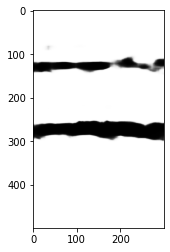

In [21]:
import matplotlib.pyplot as plt
from torchvision import transforms
# image = transforms.ToPILImage()(mak)
plt.imshow(predictions[5],cmap="Greys")

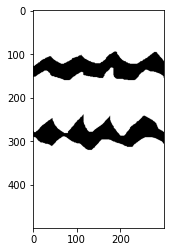

In [22]:
plt.imshow(image_list[5], cmap='Greys')

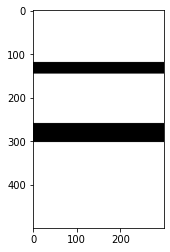

In [23]:
plt.imshow(mask_list[5],cmap="Greys")